In [4]:
# !pip install -qU av torch torchvision "transformers>=4.41.0" accelerate safetensors tokenizers sentencepiece
# restart session after this.

In [5]:
!nvidia-smi

Mon Feb  9 16:19:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:00:05.0 Off |                  Off |
| 30%   34C    P8             19W /  300W |       4MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import av
import math
import json
import requests
import psutil
import gc
from  typing import Optional, Tuple, List, Dict, Union, Any
from dataclasses import dataclass, asdict

import torch
from torch import nn
import torch.nn.functional as F

from safetensors import safe_open
from safetensors.torch import load_file as load_safetensors

from huggingface_hub import hf_hub_download, snapshot_download
from huggingface_hub import login
from transformers import VideoLlavaForConditionalGeneration as HFVideoLlava, VideoLlavaProcessor

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16
MODEL_ID = "LanguageBind/Video-LLaVA-7B-hf"
print(f"Device : {DEVICE}\nDtype : {DTYPE}")

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print(f'Cuda Memory : {(torch.cuda.get_device_properties(0).total_memory / (1024 * 1024 * 1024)):.4f} GB')
    

HF_TOKEN = os.getenv("HF_TOKEN")
login(HF_TOKEN)

Device : cuda
Dtype : torch.float16
NVIDIA RTX A6000
Cuda Memory : 47.5291 GB


In [8]:
config_path = hf_hub_download(repo_id = MODEL_ID, filename = "config.json")
with open(config_path, "r") as f:
    full_config = json.load(f)
    
print(json.dumps(full_config, indent = 2))

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

{
  "architectures": [
    "VideoLlavaForConditionalGeneration"
  ],
  "ignore_index": -100,
  "image_token_index": 32000,
  "model_type": "video_llava",
  "pad_token_id": 32002,
  "projector_hidden_act": "gelu",
  "text_config": {
    "_name_or_path": "lmsys/vicuna-7b-v1.5",
    "architectures": [
      "LlamaForCausalLM"
    ],
    "max_position_embeddings": 4096,
    "model_type": "llama",
    "pad_token_id": 0,
    "rms_norm_eps": 1e-05,
    "torch_dtype": "float16",
    "vocab_size": 32064
  },
  "torch_dtype": "bfloat16",
  "transformers_version": "4.41.0.dev0",
  "video_token_index": 32001,
  "vision_config": {
    "hidden_size": 1024,
    "intermediate_size": 4096,
    "model_type": "clip_vision_model",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "patch_size": 14,
    "projection_dim": 768,
    "vocab_size": 32000
  },
  "vision_feature_layer": -2,
  "vision_feature_select_strategy": "default",
  "vocab_size": 32064
}


In [9]:
index_path = hf_hub_download(repo_id = MODEL_ID, filename = "model.safetensors.index.json")
with open(index_path, "r") as f:
    index = json.load(f)
all_keys = sorted(index["weight_map"].keys())
print(f"Total num keys : {len(all_keys)}")

unq_modules = set(k.split(".")[0].strip() for k in all_keys)
dct = {}
for mod in unq_modules:
    dct[mod] = 0

for k in all_keys:
    mod_key = k.split(".")[0].strip()
    dct[mod_key] += 1

for k, v in dct.items():
    print(f"{k} : {v}")

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Total num keys : 1077
language_model : 291
multi_modal_projector : 4
image_tower : 391
video_tower : 391


In [10]:
def load_and_inspect_model(MODEL_ID):
    hf_model = HFVideoLlava.from_pretrained(MODEL_ID, torch_dtype = torch.float16, device_map = "cuda")
    print(hf_model)
    return None

load_and_inspect_model(MODEL_ID)
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/1077 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/148 [00:00<?, ?B/s]

VideoLlavaForConditionalGeneration(
  (model): VideoLlavaModel(
    (video_tower): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(257, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True

In [11]:
@dataclass
class LlamaConfig:
    vocab_size : int = 32064
    hidden_size : int = 4096
    intermediate_size : int = 11008
    num_hidden_layers : int = 32
    num_attention_heads : int = 32
    num_key_value_heads : int = 32
    hidden_act : str = "silu"
    max_position_embeddings : int = 4096
    rms_norm_eps : float = 1e-05
    rope_theta : float = 10_000.0
    attention_bias : bool = False
    attention_dropout : float = 0.0
    
    @classmethod
    def from_dict(cls, config_dict : dict) -> "LlamaConfig":
        text_config = config_dict.get("text_config", config_dict)
        return cls(
            vocab_size = text_config.get("vocab_size", 32064),
            hidden_size = text_config.get("hidden_size", 4096),
            intermediate_size = text_config.get("intermediate_size", 11008),
            num_hidden_layers = text_config.get("num_hidden_layers", 32),
            num_attention_heads = text_config.get("num_attention_heads", 32),
            num_key_value_heads = text_config.get("num_key_value_heads", 32),
            hidden_act = text_config.get("hidden_act", "silu"),
            max_position_embeddings = text_config.get("max_position_embeddings", 4096),
            rms_norm_eps = text_config.get("rms_norm_eps", 1e-5),
            rope_theta = text_config.get("rope_theta", 10000.0),
            attention_bias = text_config.get("attention_bias", False),
            attention_dropout = text_config.get("attention_dropout", 0.0),
        )

In [12]:
@dataclass
class CLIPVisionConfig:
    hidden_size : int = 1024
    intermediate_size : int = 4096
    num_hidden_layers: int = 24
    num_attention_heads: int = 16
    image_size: int = 224
    patch_size: int = 14
    hidden_act: str = "quick_gelu"
    layer_norm_eps: float = 1e-5
    attention_dropout: float = 0.0
    num_channels: int = 3
    
    @classmethod
    def from_dict(cls, config_dict: dict) -> "CLIPVisionConfig":
        return cls(
            hidden_size = config_dict.get("hidden_size", 1024),
            intermediate_size = config_dict.get("intermediate_size", 4096),
            num_hidden_layers = config_dict.get("num_hidden_layers", 24),
            num_attention_heads = config_dict.get("num_attention_heads", 16),
            image_size = config_dict.get("image_size", 224),
            patch_size = config_dict.get("patch_size", 14),
            hidden_act = config_dict.get("hidden_act", "quick_gelu"),
            layer_norm_eps = config_dict.get("layer_norm_eps", 1e-5),
            attention_dropout = config_dict.get("attention_dropout", 0.0),
            num_channels = config_dict.get("num_channels", 3),
        )

In [13]:
@dataclass
class VideoLlavaConfig:
    text_config : LlamaConfig = None
    vision_config : CLIPVisionConfig = None
    video_config : CLIPVisionConfig = None
    ignore_index : int = -100
    image_token_index : int = 32000
    video_token_index : int = 32001
    projector_hidden_act : str = "gelu"
    vision_feature_select_strategy : str = "default"
    vision_feature_layer : int = -2
    
    @classmethod
    def from_dict(cls, config_dict: dict) -> "VideoLlavaConfig":
        return cls(
            text_config = LlamaConfig.from_dict(config_dict),
            vision_config = CLIPVisionConfig.from_dict(config_dict.get("vision_config", {})),
            video_config = CLIPVisionConfig.from_dict(config_dict.get("video_config", config_dict.get("vision_config", {}))),
            ignore_index = config_dict.get("ignore_index", -100),
            image_token_index = config_dict.get("image_token_index", 32000),
            video_token_index = config_dict.get("video_token_index", 32001),
            projector_hidden_act = config_dict.get("projector_hidden_act", "gelu"),
            vision_feature_select_strategy = config_dict.get("vision_feature_select_strategy", "default"),
            vision_feature_layer = config_dict.get("vision_feature_layer", -2),
        )

In [14]:
video_llava_config = VideoLlavaConfig.from_dict(full_config)
print(json.dumps(asdict(video_llava_config), indent = 2))

{
  "text_config": {
    "vocab_size": 32064,
    "hidden_size": 4096,
    "intermediate_size": 11008,
    "num_hidden_layers": 32,
    "num_attention_heads": 32,
    "num_key_value_heads": 32,
    "hidden_act": "silu",
    "max_position_embeddings": 4096,
    "rms_norm_eps": 1e-05,
    "rope_theta": 10000.0,
    "attention_bias": false,
    "attention_dropout": 0.0
  },
  "vision_config": {
    "hidden_size": 1024,
    "intermediate_size": 4096,
    "num_hidden_layers": 24,
    "num_attention_heads": 16,
    "image_size": 224,
    "patch_size": 14,
    "hidden_act": "quick_gelu",
    "layer_norm_eps": 1e-05,
    "attention_dropout": 0.0,
    "num_channels": 3
  },
  "video_config": {
    "hidden_size": 1024,
    "intermediate_size": 4096,
    "num_hidden_layers": 24,
    "num_attention_heads": 16,
    "image_size": 224,
    "patch_size": 14,
    "hidden_act": "quick_gelu",
    "layer_norm_eps": 1e-05,
    "attention_dropout": 0.0,
    "num_channels": 3
  },
  "ignore_index": -100,
  "

In [15]:
def tiny_llama_config():
    return LlamaConfig(
        vocab_size = 32064,
        hidden_size = 256,
        intermediate_size = 1024,
        num_hidden_layers = 2,
        num_attention_heads = 4,
        num_key_value_heads = 4,
        max_position_embeddings = 256,
        rms_norm_eps = 1e-5,
        rope_theta = 10000.0,
        attention_bias = False,
        attention_dropout = 0.0
    )

def tiny_clip_config():
    return CLIPVisionConfig(
        hidden_size = 128,
        intermediate_size = 512,
        num_hidden_layers = 2,
        num_attention_heads = 4,
        image_size = 224,
        patch_size = 14,
        hidden_act = "quick_gelu",
        layer_norm_eps = 1e-5,
        attention_dropout = 0.0,
        num_channels = 3
    )

def tiny_video_llava_config():
    return VideoLlavaConfig(
        text_config = tiny_llama_config(),
        vision_config = tiny_clip_config(),
        video_config = tiny_clip_config(),
        image_token_index = 32000,
        video_token_index = 32001,
        projector_hidden_act = "gelu",
        vision_feature_select_strategy = "default",
        vision_feature_layer = -2,
    )

test_llama_config = tiny_llama_config()
test_vision_config = tiny_clip_config()
test_llava_config = tiny_video_llava_config()
count_params = lambda m : f"{sum(p.numel() for p in m.parameters()):,} params"

In [16]:
class LlamaRMSNorm(nn.Module):
    def __init__(self, hidden_size : int, eps : float = 1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps
    
    def forward(self, hidden_tensor : torch.Tensor) -> torch.Tensor:
        input_dtype = hidden_tensor.dtype
        hidden_tensor = hidden_tensor.to(torch.float32)
        variance = hidden_tensor.pow(2).mean(dim = -1, keepdim = True)
        hidden_tensor = hidden_tensor * torch.rsqrt(variance + self.variance_epsilon)
        hidden_tensor = hidden_tensor.to(input_dtype)
        return self.weight * hidden_tensor
    

sample_llama_rms_norm = LlamaRMSNorm(hidden_size = test_llama_config.hidden_size, eps = test_llama_config.rms_norm_eps)
print(count_params(sample_llama_rms_norm))
sample_input = torch.randn([2, 10, test_llama_config.hidden_size])
print(sample_llama_rms_norm(sample_input).shape)

256 params
torch.Size([2, 10, 256])


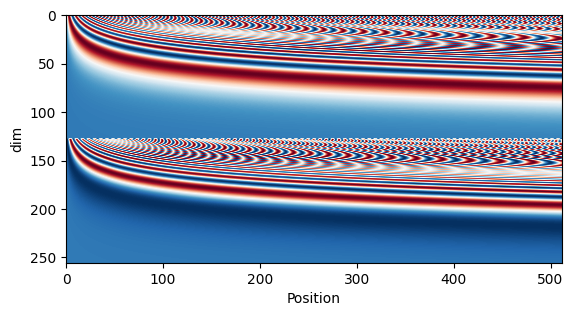

In [17]:
class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, 
                 dim, 
                 max_position_embeddings : int = 4096, 
                 base : float = 10000.0, 
                 device : Optional[torch.device] = None):
        super().__init__()
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        self.device = device
    
        inv_freq = 1 / (self.base ** (torch.arange(0, dim, 2) / dim))
        self.register_buffer("inv_freq", inv_freq, persistent = False) # [dim // 2,]
        self._set_cos_sin_cache(max_position_embeddings, device = device, dtype = torch.float32)
    
    def _set_cos_sin_cache(self, 
                           seq_len : int, 
                           device : Optional[torch.device] = None, 
                           dtype : torch.dtype = torch.float32):
        self.max_seq_len_cached = max(getattr(self, "max_seq_len_cached", 0), seq_len)
        pos = torch.arange(0, seq_len, dtype = dtype, device = device)
        freq = torch.outer(pos, self.inv_freq.to(device)) # [seq_len, dim // 2]
        embed = torch.cat([freq, freq], dim = -1) # [seq_len, dim]
        self.register_buffer("sin_cached", embed.sin().to(dtype), persistent = False)
        self.register_buffer("cos_cached", embed.cos().to(dtype), persistent = False)
    
    def forward(self, x : torch.Tensor, position_ids : torch.Tensor):
        seq_len = position_ids.max() + 1
        if self.max_seq_len_cached < seq_len:
            self._set_cos_sin_cache(seq_len, device = x.device, dtype = x.dtype)
        cos = self.cos_cached[position_ids].to(x.dtype)
        sin = self.sin_cached[position_ids].to(x.dtype)
        return cos, sin

def rotate_half(x : torch.Tensor):
    x_1 = x[..., : x.shape[-1] // 2]
    x_2 = x[..., x.shape[-1] // 2 :]
    return torch.cat([-x_2, x_1], dim = -1)

def apply_rotary_position_emb(q, k, cos, sin, unsqueeze_dim : int = 1):
    # q : [batch_size, num_heads, seq_len, head_dim]
    # k : [batch_size, num_heads, seq_len, head_dim]
    # cos : [1, seq_len, head_dim]
    # sin : [1, seq_len, head_dim]
    
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_emb = (q * cos) + (rotate_half(q) * sin)
    k_emb = (k * cos) + (rotate_half(k) * sin)
    return q_emb, k_emb

sample_rot_emb = LlamaRotaryEmbedding(dim = test_llama_config.hidden_size, 
                                      max_position_embeddings = test_llama_config.max_position_embeddings, 
                                      base = test_llama_config.rope_theta)
q = torch.ones([1, 1, 512, test_llama_config.hidden_size])
sample_pos_ids = torch.arange(0, 512, dtype = torch.int64)
cos, sin = sample_rot_emb(q, sample_pos_ids)
cos, sin = cos.unsqueeze(dim = 0), sin.unsqueeze(dim = 0)

q_rot, _ = apply_rotary_position_emb(q, q, cos, sin)
q_rot = q_rot.squeeze().cpu().numpy()
plt.imshow(q_rot.T, cmap = "RdBu")
plt.xlabel("Position")
plt.ylabel("dim")
plt.show()

In [18]:
class LlamaAttention(nn.Module):
    def __init__(self, config : LlamaConfig, layer_idx : int):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        
        if self.hidden_size % self.num_heads != 0:
            raise ValueError(f"hidden_dim ({self.hidden_size}) must be divisible by num_heads ({self.num_heads})")
        self.head_dim = self.hidden_size // self.num_heads
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.attention_dropout = config.attention_dropout
        
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias = config.attention_bias)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias = config.attention_bias)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias = config.attention_bias)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias = config.attention_bias)
        self.rotary_emb = LlamaRotaryEmbedding(dim = self.head_dim, 
                                               max_position_embeddings = config.max_position_embeddings, 
                                               base = config.rope_theta)
    
    def forward(self, 
                hidden_states : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None,
                position_ids : Optional[torch.Tensor] = None,
                past_key_value : Optional[Tuple[torch.Tensor, torch.Tensor]] = None, 
                output_attentions : bool = False, 
                use_cache : bool = False):
        
        batch_size, seq_len, _ = hidden_states.shape
        
        q_state = self.q_proj(hidden_states).reshape([batch_size, seq_len, self.num_heads, self.head_dim])
        k_state = self.k_proj(hidden_states).reshape([batch_size, seq_len, self.num_key_value_heads, self.head_dim])
        v_state = self.v_proj(hidden_states).reshape([batch_size, seq_len, self.num_key_value_heads, self.head_dim])
        
        q_state = q_state.contiguous().transpose(1, 2) # [batch_size, num_heads, seq_len, head_dim]
        k_state = k_state.contiguous().transpose(1, 2)
        v_state = v_state.contiguous().transpose(1, 2)
        
        if position_ids is None:
            position_ids = torch.arange(0, seq_len, dtype = torch.int64).unsqueeze(0).expand(batch_size, seq_len) 
            # [batch_size, seq_len]
            
        cos, sin = self.rotary_emb(q_state, position_ids)
        q_state, k_state = apply_rotary_position_emb(q_state, k_state, cos, sin, unsqueeze_dim = 1)
        
        if past_key_value is not None:
            past_key, past_value = past_key_value
            k_state = torch.cat([past_key, k_state], dim = 2)
            v_state = torch.cat([past_value, v_state], dim = 2)
        
        past_key_value = (k_state, v_state) if use_cache else None
        k_state = self._repeat_kv(k_state, self.num_key_value_groups)
        v_state = self._repeat_kv(v_state, self.num_key_value_groups)
        
        
        attn_wts = torch.matmul(q_state, k_state.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if attention_mask is not None:
            attn_wts += attention_mask
        attn_wts = F.softmax(attn_wts, dim = -1, dtype = torch.float32).to(q_state.dtype)
        attn_output = torch.matmul(attn_wts, v_state).transpose(1, 2)
        attn_output = attn_output.contiguous().reshape(batch_size, seq_len, self.hidden_size)
        attn_output = self.o_proj(attn_output)
        
        if not output_attentions:
            attn_wts = None
        
        return attn_output, attn_wts, past_key_value
    
    def _repeat_kv(self, x : torch.Tensor, n_rep : int):
        if n_rep == 1:
            return x
        batch_size, num_heads, seq_len, head_dim = x.shape
        x = x[:, :, None, :, :].expand(batch_size, num_heads, n_rep, seq_len, head_dim)
        return x.reshape([batch_size, num_heads * n_rep, seq_len, head_dim])

sample_llama_attn = LlamaAttention(test_llama_config, layer_idx = 0)
sample_x = torch.randn([2, 10, test_llama_config.hidden_size])
sample_attn_mask = torch.triu(torch.full((10, 10), -float("inf")), diagonal = 1).unsqueeze(0).unsqueeze(0)
sample_pos_ids = torch.arange(10, dtype = torch.int64)[None, :].expand(2, 10)
sample_out, _, _ = sample_llama_attn(sample_x, sample_attn_mask, sample_pos_ids)
print(sample_out.shape)

torch.Size([2, 10, 256])


In [19]:
class LlamaMLP(nn.Module):
    def __init__(self, config : LlamaConfig):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias = False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias = False)
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias = False)
        self.act_fn = nn.SiLU()
    
    def forward(self, x : torch.Tensor):
        gate_out = self.act_fn(self.gate_proj(x))
        up_out = self.up_proj(x)
        return self.down_proj(up_out * gate_out)

sample_mlp = LlamaMLP(test_llama_config)
sample_inp = torch.randn([2, 10, test_llama_config.hidden_size])
print(sample_mlp(sample_inp).shape)

torch.Size([2, 10, 256])


In [20]:
class LlamaDecoderLayer(nn.Module):
    def __init__(self, config : LlamaConfig, layer_idx : int):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.self_attn = LlamaAttention(config, layer_idx)
        self.mlp = LlamaMLP(config)
        self.input_layernorm = LlamaRMSNorm(hidden_size = config.hidden_size, eps = config.rms_norm_eps)
        self.post_attention_layernorm = LlamaRMSNorm(hidden_size = config.hidden_size, eps = config.rms_norm_eps)
    
    def forward(self, 
                hidden_states : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None,
                position_ids : Optional[torch.Tensor] = None,
                past_key_value : Optional[Tuple[torch.Tensor, torch.Tensor]] = None, 
                output_attentions : bool = False, 
                use_cache : bool = False):
        res = hidden_states
        hidden_states = self.input_layernorm(hidden_states)
        hidden_states, attn_weights, past_key_value = self.self_attn(hidden_states, 
                                                                     attention_mask, 
                                                                     position_ids, 
                                                                     past_key_value, 
                                                                     output_attentions, 
                                                                     use_cache)
        hidden_states += res
        res = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states += res
        
        output = (hidden_states, )
        if output_attentions:
            output += (attn_weights, )
        if use_cache:
            output += (past_key_value, )
        
        return output
    
sample_decoder_layer = LlamaDecoderLayer(test_llama_config, layer_idx = 0)
sample_inp = torch.randn([2, 10, test_llama_config.hidden_size])
print(sample_decoder_layer(sample_inp)[0].shape)

torch.Size([2, 10, 256])


In [21]:
def _prepare_4d_causal_mask_attention(attention_mask_2d : torch.Tensor, 
                                      q_len : int, 
                                      past_len : int, 
                                      dtype : torch.dtype, 
                                      device : torch.device):
    
    batch_size = attention_mask_2d.size(0)
    total_kv_len = q_len + past_len
    MIN_VAL = torch.finfo(torch.float32).min
    
    if attention_mask_2d.size(1) < total_kv_len:
        pad_len = total_kv_len - attention_mask_2d.size(1)
        attention_mask_2d = F.pad(attention_mask_2d, (0, pad_len), value = 1)
    elif total_kv_len < attention_mask_2d.size(1):
        attention_mask_2d = attention_mask_2d[:, : total_kv_len]
    
    causal_mask = torch.zeros([q_len, total_kv_len], device = device, dtype = torch.float32)
    causal_mask = torch.triu(torch.full_like(causal_mask, MIN_VAL), diagonal = past_len + 1)
    causal_mask = causal_mask[None, None, :, :].expand([batch_size, 1, q_len, total_kv_len])
    key_pad_mask = (attention_mask_2d == 0)[:, None, None, :].expand([batch_size, 1, q_len, total_kv_len])
    causal_mask = causal_mask.masked_fill(key_pad_mask, MIN_VAL)
    return causal_mask.to(dtype)

In [22]:
class LlamaModel(nn.Module):
    def __init__(self, config : LlamaConfig):
        super().__init__()
        self.config = config
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)
        self.layers = nn.ModuleList([LlamaDecoderLayer(config, layer_idx = i) for i in range(config.num_hidden_layers)])
        self.norm = LlamaRMSNorm(config.hidden_size, config.rms_norm_eps)
    
    def forward(self, 
                input_ids : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None, 
                position_ids : Optional[torch.Tensor] = None, 
                past_key_values : Optional[Tuple[torch.Tensor, torch.Tensor]] = None, 
                input_embeds : Optional[torch.Tensor] = None, 
                use_cache : bool = False, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        
        if input_embeds is None:
            input_embeds = self.embed_tokens(input_ids)
        
        batch_size, seq_len = input_embeds.shape[: 2]
        past_len = 0
        if past_key_values and len(past_key_values) > 1:
            # [(pk_l1, pv_l1), (pk_l2, pv_l2), ....]
            past_len = past_key_values[0][0].shape[2]
        
        if position_ids is None:
            position_ids = torch.arange(past_len, past_len + seq_len, dtype = torch.int64, device = input_ids.device).unsqueeze(0)
        
        if attention_mask is None:
            attention_mask = self._create_causal_mask(batch_size, seq_len, past_len, input_embeds.dtype, input_embeds.device)
        elif attention_mask.dim() == 2:
            attention_mask = _prepare_4d_causal_mask_attention(attention_mask, seq_len, past_len, input_embeds.dtype, input_embeds.device)
        elif attention_mask.dim() == 4:
            pass
        else:
            raise ValueError(f"Attention Mask must be either 2D or 4D, but current attention_mask is {attention_mask.dim()} D")
        
        hidden_states = input_embeds
        all_hidden_states = [] if output_hidden_states else None
        all_attentions = [] if output_attentions else None
        next_cache = [] if use_cache else None
        
        for li, layer in enumerate(self.layers):
            if output_hidden_states:
                all_hidden_states.append(hidden_states)
            past_kv = past_key_values[li] if past_key_values else None
            layer_out = layer(hidden_states, attention_mask, position_ids, past_kv, output_attentions, use_cache)            
            hidden_states = layer_out[0]
            
            if output_attentions:
                all_attentions.append(layer_out[1])
            if use_cache:
                next_cache.append(layer_out[-1])
            
        hidden_states = self.norm(hidden_states)
        if output_hidden_states:
            all_hidden_states.append(hidden_states)
        
        return tuple(v for v in [hidden_states, next_cache, all_hidden_states, all_attentions] if v is not None)
    
    def _create_causal_mask(self, 
                            batch_size : int, 
                            seq_len : int, 
                            past_len : int, 
                            dtype : torch.dtype, 
                            device : torch.device):
        tot = past_len + seq_len
        MIN_VAL = torch.finfo(torch.float32).min
        mask = torch.triu(torch.full((seq_len, tot), MIN_VAL, dtype = torch.float32, device = device), diagonal = past_len + 1)
        return mask.unsqueeze(0).unsqueeze(0).expand(batch_size, 1, -1, -1).to(dtype)

sample_llama_model = LlamaModel(test_llama_config)
print(count_params(sample_llama_model))
sample_input_ids = torch.tensor([[10, 11, 12, 13, 14], [15, 16, 17, 18, 19]])
sample_llama_out = sample_llama_model(input_ids = sample_input_ids)
for val in sample_llama_out:
    try:
        print(f"{val.shape}")
    except:
        pass

del sample_llama_model
gc.collect()
print()

10,306,816 params
torch.Size([2, 5, 256])



In [23]:
class LlamaForCausalLM(nn.Module):
    def __init__(self, config : LlamaConfig):
        super().__init__()
        self.config = config
        self.model = LlamaModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias = False)
    
    def forward(self, 
                input_ids : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None, 
                position_ids : Optional[torch.Tensor] = None, 
                past_key_values : Optional[Tuple[torch.Tensor, torch.Tensor]] = None, 
                input_embeds : Optional[torch.Tensor] = None, 
                labels : Optional[torch.Tensor] = None,
                use_cache : bool = False, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        outputs = self.model(input_ids, 
                            attention_mask, 
                            position_ids, 
                            past_key_values, 
                            input_embeds, 
                            use_cache, 
                            output_attentions, 
                            output_hidden_states)
        hidden_states = outputs[0]
        logits = self.lm_head(hidden_states)
        loss = None
        if labels is not None:
            labels_shifted = labels[:, 1:]
            logits_shifted = logits[:, :-1, :]
            loss = F.cross_entropy(logits_shifted.view(-1, self.config.vocab_size), labels_shifted.view(-1))
        return (logits, loss) + outputs[1 :]
    
sample_llama = LlamaForCausalLM(test_llama_config)
print(count_params(sample_llama))
sample_input_ids = torch.tensor([[10, 11, 12, 13, 14], [15, 16, 17, 18, 19]])
sample_llama_out = sample_llama(input_ids = sample_input_ids)
for val in sample_llama_out:
    try:
        print(f"{val.shape}")
    except:
        pass

del sample_llama
gc.collect()
print()

18,515,200 params
torch.Size([2, 5, 32064])



In [24]:
class CLIPVisionEmbeddings(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.config = config
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_patches = ((self.image_size // self.patch_size) ** 2)
        self.num_pos = self.num_patches + 1
        self.patch_embedding = nn.Conv2d(in_channels = config.num_channels, 
                                         out_channels = config.hidden_size, 
                                         kernel_size = self.patch_size, 
                                         stride = self.patch_size, 
                                         bias = False)
        self.position_embedding = nn.Embedding(self.num_pos, config.hidden_size)
        self.class_embedding = nn.Parameter(torch.randn(config.hidden_size))
        self.register_buffer("position_ids", torch.arange(self.num_pos).expand(1, -1), persistent = False)
    
    def forward(self, img : torch.Tensor):
        # [batch_size, C, H, W]
        batch_size = img.shape[0]
        img_emb = self.patch_embedding(img).flatten(2) # [B, dim, num_patches]
        img_emb = img_emb.transpose(1, 2).contiguous() # [B, num_patches, dim]
        cls_emb = self.class_embedding.expand(batch_size, 1, -1)
        return torch.concat([cls_emb, img_emb], dim = 1) + self.position_embedding(self.position_ids)

sample_clip_vis_emb = CLIPVisionEmbeddings(test_vision_config)
print(count_params(sample_clip_vis_emb))
sample_img = torch.randn([2, 3, 224, 224], dtype = torch.float32)
sample_clip_emb_out = sample_clip_vis_emb(sample_img)
print(sample_clip_emb_out.shape)
del sample_clip_vis_emb
gc.collect()
print()

108,288 params
torch.Size([2, 257, 128])



In [25]:
class CLIPAttention(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        if self.hidden_size % self.num_heads != 0:
            raise ValueError(f"Hidden Size {self.hidden_size} must be divisible by num_heads {num_heads}")
        self.head_dim = self.hidden_size // self.num_heads
        self.dropout = config.attention_dropout
        
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.k_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.v_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim)
        self.out_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size)
        
    
    def forward(self, 
                hidden_states : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None, 
                causal_attention_mask : Optional[torch.Tensor] = None, 
                output_attentions : bool = False):
        
        batch_size, seq_len, _ = hidden_states.shape
        q = self.q_proj(hidden_states).reshape([batch_size, seq_len, self.num_heads, self.head_dim])
        k = self.k_proj(hidden_states).reshape([batch_size, seq_len, self.num_heads, self.head_dim])
        v = self.v_proj(hidden_states).reshape([batch_size, seq_len, self.num_heads, self.head_dim])
        
        q = q.transpose(1, 2).contiguous()
        k = k.transpose(1, 2).contiguous()
        v = v.transpose(1, 2).contiguous()
        
        attn_wts = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if attention_mask is not None:
            attn_wts += attention_mask
        if causal_attention_mask is not None:
            attn_wts += causal_attention_mask
        
        attn_wts = F.softmax(attn_wts, dim = -1, dtype = torch.float32).to(hidden_states.dtype)
        attn_wts = F.dropout(attn_wts, p = self.dropout, training = self.training)
        
        
        attn_out = torch.matmul(attn_wts, v) # [batch_size, num_heads, seq_len, head_dim]
        attn_out = attn_out.transpose(1, 2).contiguous()
        attn_out = attn_out.reshape([batch_size, seq_len, -1])
        attn_out = self.out_proj(attn_out)
        
        return attn_out, attn_wts if output_attentions else None
    
sample_clip_attn = CLIPAttention(test_vision_config)
num_positions = (test_vision_config.image_size // test_vision_config.patch_size) ** 2 + 1
sample_x = torch.randn([2, num_positions, test_vision_config.hidden_size])
sample_out = sample_clip_attn(sample_x)
print(sample_out[0].shape)

torch.Size([2, 257, 128])


In [26]:
def quick_gelu(x : torch.Tensor):
    return x * torch.sigmoid(1.702 * x)

class CLIPMLP(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.activation_fn = quick_gelu if config.hidden_act == "quick_gelu" else F.gelu
    
    def forward(self, x : torch.Tensor):
        return self.fc2(self.activation_fn(self.fc1(x)))

clip_mlp = CLIPMLP(test_vision_config)
x = torch.randn([2, 10, test_vision_config.hidden_size])
print(clip_mlp(x).shape)

torch.Size([2, 10, 128])


In [27]:
class CLIPEncoderLayer(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.config = config
        self.self_attn = CLIPAttention(config)
        self.mlp = CLIPMLP(config)
        self.layer_norm1 = nn.LayerNorm(config.hidden_size, eps = config.layer_norm_eps)
        self.layer_norm2 = nn.LayerNorm(config.hidden_size, eps = config.layer_norm_eps)
    
    def forward(self, 
                hidden_states : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None, 
                causal_attention_mask : Optional[torch.Tensor] = None, 
                output_attentions : bool = False):
        
        res = hidden_states
        hidden_states = self.layer_norm1(hidden_states)
        hidden_states, attn_wts = self.self_attn(hidden_states, attention_mask, causal_attention_mask, output_attentions)
        hidden_states = hidden_states + res
        
        res = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = hidden_states + res
        
        return hidden_states, attn_wts

sample_enc_layer = CLIPEncoderLayer(test_vision_config)
num_positions = (test_vision_config.image_size // test_vision_config.patch_size) ** 2 + 1
x = torch.randn([2, num_positions, test_vision_config.hidden_size])
sample_out = sample_enc_layer(x)
print(sample_out[0].shape)

torch.Size([2, 257, 128])


In [28]:
class CLIPEncoder(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.layers = nn.ModuleList([CLIPEncoderLayer(config) for _ in range(config.num_hidden_layers)])
    
    def forward(self, 
                hidden_states : torch.Tensor, 
                attention_mask : Optional[torch.Tensor] = None, 
                causal_attention_mask : Optional[torch.Tensor] = None, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        
        all_attentions = [] if output_attentions else None
        all_hidden_states = [] if output_hidden_states else None
        
        for layer in self.layers:
            if output_hidden_states:
                all_hidden_states.append(hidden_states)
            hidden_states, attn_wts = layer(hidden_states, attention_mask, causal_attention_mask, output_attentions)
            if output_attentions:
                all_attentions.append(attn_wts)
        if output_hidden_states:
            all_hidden_states.append(hidden_states)
        return tuple(v for v in [hidden_states, all_hidden_states, all_attentions] if v is not None)

sample_enc_layer = CLIPEncoder(test_vision_config)
num_positions = (test_vision_config.image_size // test_vision_config.patch_size) ** 2 + 1
x = torch.randn([2, num_positions, test_vision_config.hidden_size])
sample_out = sample_enc_layer(x)
print(sample_out[0].shape)

torch.Size([2, 257, 128])


In [29]:
class CLIPVisionTransformer(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.embeddings = CLIPVisionEmbeddings(config)
        self.pre_layrnorm = nn.LayerNorm(config.hidden_size, eps = config.layer_norm_eps)
        self.encoder = CLIPEncoder(config)
        self.post_layernorm = nn.LayerNorm(config.hidden_size, eps = config.layer_norm_eps)
    
    def forward(self, 
                img : torch.Tensor, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        hidden_states = self.embeddings(img)
        hidden_states = self.pre_layrnorm(hidden_states)
        encoder_output = self.encoder(hidden_states = hidden_states, output_attentions = output_attentions, output_hidden_states = output_hidden_states)
        hidden_states = encoder_output[0]
        cls_out = hidden_states[:, 0, :]
        cls_out = self.post_layernorm(cls_out)
        return (hidden_states, cls_out) + encoder_output[1 :]

sample_img = torch.randn([2, 3, test_vision_config.image_size, test_vision_config.image_size])
sample_vis = CLIPVisionTransformer(test_vision_config)
sample_out = sample_vis(sample_img)
print(sample_out[0].shape)
print(sample_out[1].shape)

torch.Size([2, 257, 128])
torch.Size([2, 128])


In [30]:
class CLIPVisionModel(nn.Module):
    def __init__(self, config : CLIPVisionConfig):
        super().__init__()
        self.vision_model = CLIPVisionTransformer(config)
    
    def forward(self, 
                img : torch.Tensor, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        return self.vision_model(img, output_attentions, output_hidden_states)

sample_clip_vis_model = CLIPVisionModel(test_vision_config)
sample_img = torch.randn([2, 3, test_vision_config.image_size, test_vision_config.image_size])
sample_out = sample_clip_vis_model(sample_img)
print(sample_out[0].shape)
print(sample_out[1].shape)

torch.Size([2, 257, 128])
torch.Size([2, 128])


In [31]:
class VideoLlavaMultiModalProjector(nn.Module):
    def __init__(self, vision_hidden_size : int, text_hidden_size : int):
        super().__init__()
        self.linear_1 = nn.Linear(vision_hidden_size, text_hidden_size)
        self.linear_2 = nn.Linear(text_hidden_size, text_hidden_size)
        self.act = nn.GELU()
    
    def forward(self, vis_hidden_state : torch.Tensor):
        return self.linear_2(self.act(self.linear_1(vis_hidden_state)))

num_pos = ((test_vision_config.image_size // test_vision_config.patch_size) ** 2) + 1
x = torch.randn([2, num_pos, test_vision_config.hidden_size])
sample_proj = VideoLlavaMultiModalProjector(test_vision_config.hidden_size, test_llama_config.hidden_size)
sample_out = sample_proj(x)
print(sample_out.shape)

torch.Size([2, 257, 256])


In [32]:
class VideoLlavaForConditionalGeneration(nn.Module):
    def __init__(self, config : VideoLlavaConfig):
        super().__init__()
        self.config = config
        self.video_tower = CLIPVisionModel(config.video_config)
        self.image_tower = CLIPVisionModel(config.vision_config)
        self.language_model = LlamaForCausalLM(config.text_config)
        self.multi_modal_projector = VideoLlavaMultiModalProjector(config.vision_config.hidden_size, config.text_config.hidden_size)
        
        self.image_token_index = config.image_token_index
        self.video_token_index = config.video_token_index
        self.vision_feature_layer = config.vision_feature_layer
        self.vision_feature_select_strategy = config.vision_feature_select_strategy
    
    def _get_vision_features(self, img : torch.Tensor, tower : CLIPVisionModel):
        tower_out = tower(img, output_hidden_states = True)
        if len(tower_out) > 2 and tower_out[2] is not None:
            feats = tower_out[2][self.vision_feature_layer]
        else:
            feats = tower_out[0]
        
        if self.vision_feature_select_strategy == "default":
            feats = feats[:, 1:, :]
        return feats
    
    def _merge_vision_text(self, 
                           img_feats : torch.Tensor, 
                           input_embeds : torch.Tensor, 
                           input_ids : torch.Tensor, 
                           attn_mask : torch.Tensor, 
                           special_token_id : int):
        # img_feats : [batch_size, num_p, dim]
        # input_embeds : [batch_size, seq_len, dim]
        # input_ids : [batch_size, seq_len]
        # attn_mask : [batch_size, seq_len]
        
        batch_size, seq_len = input_ids.shape
        num_vis_tokens = img_feats.shape[1]
        new_embeds = []
        new_masks = []
        
        for b in range(batch_size):
            pos = (input_ids[b] == special_token_id).nonzero(as_tuple = True)[0]
            if len(pos) == 0:
                new_embeds.append(input_embeds[b])
                new_masks.append(attn_mask[b])
                continue
            
            first_pos, last_pos = pos[0].item(), pos[-1].item()
            
            num_placeholders = len(pos)
            if last_pos - first_pos + 1 != num_placeholders:
                print("Found non consecutive vision tokens. Setting to default, last_pos = first_pos")
                last_pos = first_pos
                num_placeholders = 1
            
            vis_idx = min(b, img_feats.shape[0] - 1)
            vis_feats = img_feats[b]
            
            before_vis = input_embeds[b, :first_pos]
            after_vis = input_embeds[b, last_pos + 1:]
            merged_vis = torch.cat([before_vis, vis_feats, after_vis], dim = 0)
            
            before_vis_mask = attn_mask[b, :first_pos]
            after_vis_mask = attn_mask[b, last_pos + 1:]
            vision_mask = torch.ones(num_vis_tokens, dtype = attn_mask.dtype, device = attn_mask.device)
            merged_vis_mask = torch.cat([before_vis_mask, vision_mask, after_vis_mask], dim = 0)
            
            new_embeds.append(merged_vis)
            new_masks.append(merged_vis_mask)
        
        max_len = max(emb.shape[0] for emb in new_embeds)
        padded_embeds, padded_masks = [], []
        
        for emb, mask in zip(new_embeds, new_masks):
            pad_len = max_len - emb.shape[0]
            if pad_len > 0:
                emb = F.pad(emb, (0, 0, 0, pad_len))
                mask = F.pad(mask, (0, pad_len))
            padded_embeds.append(emb)
            padded_masks.append(mask)
        
        all_embeds = torch.stack(padded_embeds)
        all_masks = torch.stack(padded_masks)
        all_pos = torch.arange(max_len, dtype = torch.int64, device = input_ids.device).unsqueeze(0).expand(batch_size, -1)
        return all_embeds, all_masks, all_pos
    
    def forward(self, 
                input_ids : torch.Tensor,
                pixel_values_images : Optional[torch.Tensor] = None,
                pixel_values_videos : Optional[torch.Tensor] = None,
                attention_mask : Optional[torch.Tensor] = None, 
                position_ids : Optional[torch.Tensor] = None, 
                past_key_values : Optional[Tuple[torch.Tensor, torch.Tensor]] = None, 
                input_embeds : Optional[torch.Tensor] = None, 
                labels : Optional[torch.Tensor] = None,
                use_cache : bool = False, 
                output_attentions : bool = False, 
                output_hidden_states : bool = False):
        if input_embeds is None:
            input_embeds = self.language_model.model.embed_tokens(input_ids)
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if pixel_values_images is not None:
            img_feats = self._get_vision_features(pixel_values_images, self.image_tower)
            img_feats = self.multi_modal_projector(img_feats)
            input_embeds, attention_mask, position_ids = self._merge_vision_text(img_feats, 
                                                                                 input_embeds, 
                                                                                 input_ids, 
                                                                                 attention_mask, 
                                                                                 self.image_token_index)
        if pixel_values_videos is not None:
            batch_size, num_frames, c, h, w = pixel_values_videos.shape
            pixel_values_videos = pixel_values_videos.reshape([batch_size * num_frames, c, h, w])
            vid_feats = self._get_vision_features(pixel_values_videos, self.video_tower) # [batch_size * num_frames, num_patches, hidden_size]
            num_patches, hidden_size = vid_feats.shape[-2 :]
            vid_feats = vid_feats.reshape([batch_size, num_frames, num_patches, hidden_size])
            num_placeholders = (input_ids == self.video_token_index).sum(dim = 1).max().item()
            if num_placeholders > num_patches:
                vid_feats = vid_feats.reshape([batch_size, num_frames * num_patches, hidden_size])
            else:
                vid_feats = vid_feats.mean(dim = 1)
            vid_feats = self.multi_modal_projector(vid_feats)
            input_embeds, attention_mask, position_ids = self._merge_vision_text(vid_feats, 
                                                                                 input_embeds, 
                                                                                 input_ids, attention_mask, 
                                                                                 self.video_token_index)
        
        output = self.language_model(input_ids = input_ids, 
                                     attention_mask = attention_mask, 
                                     position_ids = position_ids, 
                                     past_key_values = past_key_values, 
                                     input_embeds = input_embeds, 
                                     labels = labels, 
                                     use_cache = use_cache, 
                                     output_attentions = output_attentions, 
                                     output_hidden_states = output_hidden_states)
        return output
    
    @torch.no_grad()
    def generate(self, 
                 input_ids : torch.Tensor, 
                 pixel_values_images : Optional[torch.Tensor] = None, 
                 pixel_values_videos : Optional[torch.Tensor] = None, 
                 attention_mask : Optional[torch.Tensor] = None, 
                 max_new_tokens : int = 256, 
                 do_sample : bool = False, 
                 temperature : float = 1.0, 
                 **kwargs):
        output = self.forward(input_ids = input_ids, 
                              pixel_values_images = pixel_values_images, 
                              pixel_values_videos = pixel_values_videos, 
                              attention_mask = attention_mask, 
                              use_cache = True)
        logits = output[0]
        past_key_values = output[2] if len(output) > 2 else None
        next_logits = logits[:, -1, :]
        if do_sample:
            next_logits = next_logits / temperature
            next_token = F.multinomial(F.softmax(next_logits, dim = -1), num_samples = 1)
        else:
            next_token = next_logits.argmax(dim = -1, keepdim = True)
        generated = [next_token]
        
        for _ in range(max_new_tokens - 1):
            output = self.language_model(input_ids = next_token, past_key_values = past_key_values, use_cache = True)
            logits = output[0]
            next_logits = logits[:, -1, :]
            past_key_values = output[2] if len(output) > 2 else None
            if do_sample:
                next_logits = next_logits / temperature
                next_token = F.multinomial(F.softmax(next_logits, dim = -1), num_samples = 1)
            else:
                next_token = next_logits.argmax(dim = -1, keepdim = True)
            generated.append(next_token)
            
            if (next_token == 2).all():
                break
        
        generated = torch.cat(generated, dim = -1)
        return torch.cat([input_ids, generated], dim = -1)

sample_llava = VideoLlavaForConditionalGeneration(test_llava_config)
print(count_params(sample_llava))
input_ids = torch.randint(low = 5, high = 1000, size = [2, 10])
sample_img = torch.randn([2, 3, 224, 224])
out = sample_llava(input_ids, sample_img)
print(out[0].shape)
out_gen = sample_llava.generate(input_ids, sample_img)
print(out_gen.shape)

19,624,704 params
torch.Size([2, 10, 32064])
torch.Size([2, 266])


In [33]:
model_dir = snapshot_download(repo_id = MODEL_ID, cache_dir = "./model_cache", allow_patterns = ["*.safetensor", "*.json"])
safetensors_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".safetensors")])
for f in safetensors_files:
    size_mb = os.path.getsize(os.path.join(model_dir, f)) / (1024 ** 2)
    print(f"{f} : {size_mb:.2f} MB")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00001-of-00003.safetensors : 4749.29 MB
model-00002-of-00003.safetensors : 4718.20 MB
model-00003-of-00003.safetensors : 4582.71 MB


In [34]:
print(f"{psutil.virtual_memory().percent} % utilized from {(psutil.virtual_memory().total / 1e9) :.2f} GB")
with torch.device("meta"):
    model = VideoLlavaForConditionalGeneration(video_llava_config)
print(f"{psutil.virtual_memory().percent} % utilized from {(psutil.virtual_memory().total / 1e9) :.2f} GB")

9.4 % utilized from 47.33 GB
9.4 % utilized from 47.33 GB


In [35]:
COMPUTED_BUFFERS = {"inv_freq", "cos_cached", "sin_cached", "position_ids"}
def is_computed_buffer(key):
    return any(key.endswith(buf) for buf in COMPUTED_BUFFERS)

our_keys = set(name for name, _ in model.named_parameters())
our_keys |= set(name for name, _ in model.named_buffers() if not(is_computed_buffer(name)))
print(f"num_keys : {len(our_keys)}")

# HF INDEX
hf_index_path = os.path.join(model_dir, "model.safetensors.index.json")
with open(hf_index_path, "r") as f:
    hf_index = json.load(f)
hf_keys = set(hf_index["weight_map"].keys())
print(f"num_hf_keys : {len(hf_keys)}")


# COMPARE
matching_keys = our_keys & hf_keys
missing_in_ours = hf_keys - our_keys
extra_in_ours = our_keys - hf_keys
print(f"matching_keys : {len(matching_keys)}")
print(f"missing_in_ours : {len(missing_in_ours)}")
print(f"extra_in_ours : {len(extra_in_ours)}")

num_keys : 1077
num_hf_keys : 1077
matching_keys : 1077
missing_in_ours : 0
extra_in_ours : 0


In [36]:
def cuda_memory_check():
    torch.cuda.synchronize()
    alloc_mem = torch.cuda.memory_allocated() / 1e9
    res_mem = torch.cuda.memory_reserved() / 1e9
    print(f"Memory Allocated : {alloc_mem} GB, Memory Reserved : {res_mem} GB")

cuda_memory_check()
model = model.to_empty(device = DEVICE)
cuda_memory_check()

Memory Allocated : 0.0 GB, Memory Reserved : 0.0 GB
Memory Allocated : 29.602919424 GB, Memory Reserved : 29.603397632 GB


In [37]:
def reinit_rope_buffers(module : nn.Module):
    if isinstance(module, LlamaRotaryEmbedding):
        inv_freq = 1 / (module.base ** (torch.arange(0, module.dim, 2, dtype = torch.float32, device = DEVICE) / module.dim))
        module.inv_freq = inv_freq
        module._set_cos_sin_cache(module.max_position_embeddings, device = DEVICE, dtype = torch.float32)
    elif isinstance(module, CLIPVisionEmbeddings):
        module.position_ids = torch.arange(module.num_pos, device = DEVICE).expand(1, -1)
    
for name, module in model.named_modules():
    reinit_rope_buffers(module)

print(count_params(model))

7,366,279,168 params


In [38]:
def strict_strem_load_safetensors(model : nn.Module, model_dir : str, device : Optional[Union[str, torch.device]] = DEVICE):
    model = model.to(device)
    name_to_param = dict(model.named_parameters())
    name_to_buffer = dict(model.named_buffers())
    
    expected_keys = set(k for k in name_to_param.keys())
    expected_keys |= set(k for k in name_to_buffer.keys() if not is_computed_buffer(k))
    
    loaded_keys = set()
    safetensors_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".safetensors")])
    if not safetensors_files:
        raise FileNotFoundError(f"No .safetensor present in loaded {model_dir}")
    print(f"Found {len(safetensors_files)} in the {model_dir}")
    
    for safe_f in safetensors_files:
        path = os.path.join(model_dir, safe_f)
        with safe_open(path, framework = "pt", device = device) as f:
            for k in f.keys():
                if k not in expected_keys:
                    raise KeyError(f"Unexpected Key in checkpoint : {k}")
                ten = f.get_tensor(k)
                
                if k in name_to_param:
                    if ten.shape != name_to_param[k].data.shape:
                        raise ValueError(f"Shape mismatch for {k}, model shape : {ten.shape}, ckpt shape : {name_to_param[k].data.shape}")
                    name_to_param[k].data.copy_(ten)
                    
                elif k in name_to_buffer:
                    if ten.shape != name_to_buffer[k].data.shape:
                        raise ValueError(f"Shape mismatch for {k}, model shape : {ten.shape}, ckpt shape : {name_to_buffer[k].data.shape}")
                    name_to_buffer[k].data.copy_(ten)
                    
                loaded_keys.add(k)
                del ten
        gc.collect()
        torch.cuda.empty_cache()
        
    
    missed_keys = loaded_keys - expected_keys
    extra_keys = expected_keys - loaded_keys
    matched_keys = (loaded_keys & expected_keys)
    
    print(f"matched_keys : {len(matched_keys)}")
    print(f"missed_keys : {len(missed_keys)}")
    print(f"extra_keys : {len(extra_keys)}")
    
    if extra_keys:
        raise KeyError(f"Found extra keys in model. Some of them are : {list(extra_keys[: 10])}")
    
    print(f"Loaded {len(loaded_keys)} keys from ckpt to model.")
    return


strict_strem_load_safetensors(model, model_dir, DEVICE)
model = model.to(dtype = DTYPE)

Found 3 in the ./model_cache/models--LanguageBind--Video-LLaVA-7B-hf/snapshots/4cf9d8cfc76a54f46a4cb43be5368b46b7f0d736
matched_keys : 1077
missed_keys : 0
extra_keys : 0
Loaded 1077 keys from ckpt to model.


In [39]:
processor = VideoLlavaProcessor.from_pretrained(MODEL_ID)
hf_model = HFVideoLlava.from_pretrained(MODEL_ID, torch_dtype = DTYPE, device_map = "cuda")

preprocessor_config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

The image processor of type `VideoLlavaImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/66.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/1077 [00:00<?, ?it/s]

In [40]:
hf_model.eval()
model.eval()
test_input_ids = torch.randint(low = 1, high = 1000, size = [1, 20])

with torch.no_grad():
    our_hidden = model.language_model.model(test_input_ids.to(DEVICE))[0].cpu()
    if hasattr(hf_model.model.language_model, "model"):
        hf_hidden = hf_model.model.language_model.model(test_input_ids.to(DEVICE))[0]
    else:
        hf_hidden = hf_model.model.language_model(test_input_ids.to(DEVICE))[0].cpu()

print(f"our_hidden : {our_hidden.shape}, hf_hidden : {hf_hidden.shape}")
diff = (our_hidden.float() - hf_hidden.float()).abs()
print(f"Max Diff : {diff.max().item() :.2f}, Mean Diff : {diff.mean().item() :.2f}")

our_hidden : torch.Size([1, 20, 4096]), hf_hidden : torch.Size([1, 20, 4096])
Max Diff : 0.09, Mean Diff : 0.00


In [41]:
VIDEO_URL = "https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/sample_demo_1.mp4"
LOCAL_VIDEO = "/tmp/test_video.mp4"

if not os.path.exists(LOCAL_VIDEO):
    print("Downloading Video")
    res = requests.get(VIDEO_URL)
    with open(LOCAL_VIDEO, "wb") as f:
        f.write(res.content)
    print("DONE.")
    
def load_from_videos(path : str, num_frames : int = 8):
    cont = av.open(path)
    stream = cont.streams.video[0]
    if stream.frames is None or stream.frames <= 0:
        cont.close()
        cont = av.open(path)
        stream = cont.streams.video[0]

    total = stream.frames or sum(1 for _ in cont.decode(video = 0))
    indices = set(np.linspace(0, total - 1, num_frames, dtype = int))
    
    frames = []
    
    for i, f in enumerate(cont.decode(0)):
        if i in indices:
            frames.append(f.to_ndarray(format = "rgb24"))
        if len(frames) == num_frames:
            break
    
    cont.close()
    return np.stack(frames)

video_frames = load_from_videos(path = LOCAL_VIDEO, num_frames = 8)
print(f"video_frames : {video_frames.shape}")

question = "What is happening in the video ?"
prompt = f"USER : <video>\n{question}\nASSISTANT:"
inputs = processor(text = prompt, videos = video_frames, return_tensors = "pt")

num_video_tokens = (inputs["input_ids"] == hf_model.config.video_token_index).sum()
print(f"num_video_tokens : {num_video_tokens}")

with torch.no_grad():
    hf_output = hf_model.generate(input_ids = inputs["input_ids"].to(DEVICE), 
                                  pixel_values_videos = inputs["pixel_values_videos"].to(DEVICE).to(DTYPE), 
                                  attention_mask = inputs.get("attention_mask", torch.ones_like(input_ids)).to(DEVICE), 
                                  max_new_tokens = 50, 
                                  do_sample = False)

print(f"hf_output : {hf_output.shape}")
HF_TEXT = processor.batch_decode(hf_output, skip_special_tokens = True)[0]
print(f"hf_text : {HF_TEXT}")
print("\n" + "#" * 20 + "\n")
with torch.no_grad():
    hf_batch = inputs.pixel_values_videos.shape[0]
    hf_num_frames = inputs.pixel_values_videos.shape[1]
    hf_frames = inputs.pixel_values_videos.reshape([hf_batch * hf_num_frames, *inputs.pixel_values_videos.shape[2:]])
    hf_feats = hf_model.model.video_tower(hf_frames.to(DEVICE).to(DTYPE), output_hidden_states = True)
    print(f"Video Tower Output Feats Dict : {dict(hf_feats).keys()}")
    print(f"last_hidden_state : {hf_feats.last_hidden_state.shape}")
    print(f"pooler_output : {hf_feats.pooler_output.shape}")
    
    if hasattr(hf_model, "config"):
        vision_feature_layer = getattr(hf_model.config, "vision_feature_layer", None)
        vision_feature_select_strategy = getattr(hf_model.config, "vision_feature_select_strategy", None)
        print(f"vision_feature_layer : {vision_feature_layer}")
        print(f"vision_feature_select_strategy : {vision_feature_select_strategy}")
        
    if hf_feats.hidden_states is not None:
        print(f"num hidden_states : {len(hf_feats.hidden_states)}")
        
        if vision_feature_layer is None:
            vision_feature_layer = -2
        hf_vision_hidden = hf_feats.hidden_states[vision_feature_layer]
        hf_vision_no_cls = hf_vision_hidden[:, 1:, :]
        hf_vision_reshaped = hf_vision_no_cls.reshape(hf_batch, hf_num_frames, -1, hf_vision_no_cls.shape[-1])
        hf_vision_mean_pooled = hf_vision_reshaped.mean(dim = 1)
        hf_vision_concat = hf_vision_reshaped.reshape(hf_batch, hf_num_frames * hf_vision_reshaped.shape[-2], -1)
        
        print(f"hf_vision_hidden : {hf_vision_hidden.shape}")
        print(f"hf_vision_no_cls : {hf_vision_no_cls.shape}")
        print(f"hf_vision_reshaped : {hf_vision_reshaped.shape}")
        print(f"hf_vision_mean_pooled : {hf_vision_mean_pooled.shape}")
        print(f"hf_vision_concat : {hf_vision_concat.shape}")
    
del hf_model
del hf_output
gc.collect()
torch.cuda.empty_cache()

DONE.
video_frames : (8, 360, 640, 3)
num_video_tokens : 2056
hf_output : torch.Size([1, 2107])
hf_text : USER : 
What is happening in the video ?
ASSISTANT: In the video, a baby is sitting on a bed and reading a book. The baby is wearing glasses and is holding the book in their hands.

####################

Video Tower Output Feats Dict : dict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
last_hidden_state : torch.Size([8, 257, 1024])
pooler_output : torch.Size([8, 1024])
vision_feature_layer : -2
vision_feature_select_strategy : default
num hidden_states : 25
hf_vision_hidden : torch.Size([8, 257, 1024])
hf_vision_no_cls : torch.Size([8, 256, 1024])
hf_vision_reshaped : torch.Size([1, 8, 256, 1024])
hf_vision_mean_pooled : torch.Size([1, 256, 1024])
hf_vision_concat : torch.Size([1, 2048, 1024])


In [42]:
# OUR MODEL
input_ids = inputs["input_ids"].to(DEVICE)
pixel_values_videos = inputs["pixel_values_videos"].to(DEVICE).to(DTYPE)
attention_mask = inputs["attention_mask"].to(DEVICE)

with torch.no_grad():
    input_embeds = model.language_model.model.embed_tokens(input_ids)
    print(f"input_embeds : {input_embeds.shape}")
    batch_size, num_frames, c, h, w = pixel_values_videos.shape
    frames = pixel_values_videos.reshape(batch_size * num_frames, c, h, w)
    frames_feats = model._get_vision_features(frames, model.video_tower)
    print(f"frames_feats : {frames_feats.shape}")
    num_patches = frames_feats.shape[1]
    hidden_size = frames_feats.shape[2]
    frames_feats = frames_feats.view(batch_size, num_frames, num_patches, hidden_size)
    num_video_tokens = (input_ids == model.config.video_token_index).sum()
    print(f"num_video_tokens : {num_video_tokens}, num_patches : {num_patches}")
    if num_video_tokens > num_patches:
        frames_feats = frames_feats.reshape(batch_size, num_frames * num_patches, hidden_size)
    else:
        frames_feats = frames_feats.mean(dim = 1)
    frames_feats = model.multi_modal_projector(frames_feats)
    
    merged_embeds, merged_mask, merged_pos = model._merge_vision_text(frames_feats, 
                                                                      input_embeds, 
                                                                      input_ids, 
                                                                      attention_mask, 
                                                                      model.config.video_token_index)
    print(f"merged_embeds : {merged_embeds.shape}")
    print(f"merged_mask : {merged_mask.shape}")
    print(f"merged_pos : {merged_pos.shape}")
    
    expected_len = input_ids.shape[1] - num_video_tokens + frames_feats.shape[1]
    actual_len = merged_embeds.shape[1]
    print(f"expected_len : {expected_len}, actual_len : {actual_len}")
    
    video_tok_pos = (input_ids[0] == model.config.video_token_index).nonzero(as_tuple = True)[0]
    print(f"In input_ids, video tokens span from {video_tok_pos[0]} to {video_tok_pos[-1]}")
    
    outputs = model.language_model(input_ids = None,
                                   attention_mask = merged_mask,
                                   position_ids = merged_pos,
                                   input_embeds = merged_embeds,
                                   use_cache = True)
    logits = outputs[0]
    print(f"logits : {logits.shape}")
    next_tok_logits = logits[:, -1, :]
    print(f"logits has NaN: {torch.isnan(next_tok_logits).any().item()}")
    print(f"logits has Inf: {torch.isinf(next_tok_logits).any().item()}")
    print(f"logits range: [{next_tok_logits.min().item():.2f}, {next_tok_logits.max().item():.2f}]")
    
    top_5_tokens = next_tok_logits.topk(k = 5, dim = -1)
    top_5_token_indices = top_5_tokens.indices
    top_5_token_values = top_5_tokens.values
    
    print(f"top_5_token_indices : {top_5_token_indices[0].tolist()}")
    print(f"top_5_token_values : {top_5_token_values[0].tolist()}")
    top_5_tokens_str = processor.batch_decode(top_5_token_indices[0].unsqueeze(1))
    print(f"top_5_tokens_str : {top_5_tokens_str}")

input_embeds : torch.Size([1, 2074, 4096])
frames_feats : torch.Size([8, 256, 1024])
num_video_tokens : 2056, num_patches : 256
merged_embeds : torch.Size([1, 2066, 4096])
merged_mask : torch.Size([1, 2066])
merged_pos : torch.Size([1, 2066])
expected_len : 2066, actual_len : 2066
In input_ids, video tokens span from 5 to 2060
logits : torch.Size([1, 2066, 32064])
logits has NaN: False
logits has Inf: False
logits range: [-4.54, 25.67]
top_5_token_indices : [512, 450, 319, 7803, 1334]
top_5_token_values : [25.671875, 24.46875, 23.546875, 19.640625, 19.421875]
top_5_tokens_str : ['In', 'The', 'A', 'Two', 'We']


In [43]:
with torch.no_grad():
    our_output = model.generate(input_ids = input_ids, 
                                pixel_values_videos = pixel_values_videos, 
                                attention_mask = attention_mask, 
                                max_new_tokens = 50, 
                                do_sample = False)


our_text = processor.batch_decode(our_output, skip_special_tokens = True)[0]
print(our_text)
print("#" * 10)
print(f"our_text == HF_TEXT : {our_text == HF_TEXT}")

USER : 
What is happening in the video ?
ASSISTANT: In the video, a baby is sitting on a bed and reading a book. The baby is wearing glasses and is holding the book in their hands.
##########
our_text == HF_TEXT : True


In [44]:
def video_qa(model : VideoLlavaForConditionalGeneration, 
             processor : VideoLlavaProcessor, 
             video_path : str, 
             question : str = "Explain the video ?", 
             max_new_tokens : int = 256, 
             device : Union[str, torch.dtype] = DEVICE, 
             dtype : torch.dtype = DTYPE):
    
    video_frames = load_from_videos(video_path, num_frames = 8)
    prompt = f"USER: <video>\n{question}\nASSISTANT:"
    inputs = processor(text = prompt, videos = video_frames, return_tensors = "pt")
    
    input_ids = inputs['input_ids'].to(device)
    pixel_values_videos = inputs['pixel_values_videos'].to(device).to(dtype)
    attention_mask = inputs.get('attention_mask', torch.ones_like(input_ids)).to(device)
    model.eval()
    
    with torch.no_grad():
        output_ids = model.generate(input_ids = input_ids,
                                    pixel_values_videos = pixel_values_videos,
                                    attention_mask = attention_mask,
                                    max_new_tokens = max_new_tokens,
                                    do_sample = False)
    
    text = processor.batch_decode(output_ids, skip_special_tokens = True)[0] 
    if "ASSISTANT:" in text:
        text = text.split("ASSISTANT:")[-1].strip()
    return text.strip()

In [45]:
video_qa(model, processor, LOCAL_VIDEO)

'The video shows a baby sitting on a bed and reading a book. The baby is wearing glasses and is holding the book in their hands. The baby appears to be enjoying the book and is focused on the content. The scene is peaceful and calm, with the baby sitting comfortably on the bed. The video captures a heartwarming moment of a young child engaging with literature and learning.'